In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as opt
import matplotlib.pyplot as plt
from torch import Tensor
from tqdm.notebook import tqdm
from scipy.ndimage import gaussian_filter1d
from torch_geometric.data import Data

In [2]:
from torch_geometric.datasets import WordNet18RR

dataset = WordNet18RR(root='data/WordNet18RR')

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print(f'Possible types of edges: {torch.unique(data.edge_type).numpy()}')
edge_types = torch.unique(data.edge_type).numpy().shape[0]
print(f'Train edges: {data.train_mask.sum()}')
print(f'Validation edges: {data.val_mask.sum()}')
print(f'Test edges: {data.test_mask.sum()}')


Dataset: WordNet18RR():
Number of graphs: 1
Number of features: 0
Number of classes: 0

Data(edge_index=[2, 93003], edge_type=[93003], train_mask=[93003], val_mask=[93003], test_mask=[93003], num_nodes=40943)
Number of nodes: 40943
Number of edges: 93003
Average node degree: 2.27
Number of training nodes: 86835
Training node label rate: 2.12
Has isolated nodes: False
Has self-loops: True
Is undirected: False
Possible types of edges: [ 0  1  2  3  4  5  6  7  8  9 10]
Train edges: 86835
Validation edges: 3034
Test edges: 3134


In [3]:
# concatenate edge_index and edge_type in one tensor
triplets = torch.cat((data.edge_index[0], data.edge_type, data.edge_index[1])).reshape((3, -1))
triplets

tensor([[    0,     0,     1,  ..., 40933, 40934, 40935],
        [    3,     9,    10,  ...,     3,     3,     3],
        [10211, 25525,  3891,  ...,  8943,  8648,  6809]])

In [4]:
def triplets_by_mask(triplets: Tensor, mask: Tensor) -> Tensor:
  return triplets[:, torch.where(mask)[0].numpy()]

# split triples into train, validation and test
train_triplets = triplets_by_mask(triplets, data.train_mask)
val_triplets = triplets_by_mask(triplets, data.val_mask)
test_triplets = triplets_by_mask(triplets, data.test_mask)

train_triplets.shape, val_triplets.shape, test_triplets.shape

(torch.Size([3, 86835]), torch.Size([3, 3034]), torch.Size([3, 3134]))

In [5]:
from typing import Tuple

# takes head, tails and number of nodes and returns corrupded heads and tails
def corrupted_triplets(
    head: Tensor, 
    tail: Tensor, 
    nodes: int
) -> Tuple[Tensor, Tensor]:
  n = head.shape[0]
  # choose what to corrupt head or tail
  head_or_tail = torch.randint(0, 2, (n,)).bool()

  # new values
  rand_inds = torch.randint(0, nodes, size=(n,))
  head_cor = torch.where(head_or_tail, head, rand_inds)
  tail_cor = torch.where(head_or_tail, rand_inds, tail)

  return (head_cor, tail_cor)

In [6]:
class TransE(nn.Module):

  def __init__(
      self, 
      k: int, # embedding dimension
      gamma: float, # margin
      num_nodes: int, 
      num_diff_edges: int, 
      p: float # norm parameter
  ):
    super().__init__()

    # saving hyperparameters 
    self.p = p
    self.gamma = gamma
    self.num_nodes = num_nodes
    self.num_diff_edges = num_diff_edges

    # bounds for initialization
    rand_lower_bound = -6 * np.sqrt(k)
    rand_upper_bound =  6 * np.sqrt(k)
    # embeddings for relations
    self.rel_embs = torch.zeros((num_diff_edges, k))
    self.rel_embs.uniform_(rand_lower_bound, rand_upper_bound)
    self.rel_embs = F.normalize(self.rel_embs, dim=1)
    self.rel_embs = self.rel_embs.requires_grad_()

    # embeddings for enteties
    self.ent_embs = torch.zeros((num_nodes, k))
    self.ent_embs.uniform_(rand_lower_bound, rand_upper_bound)
    self.ent_embs = self.ent_embs.requires_grad_()


  # take triplet (h, l, t) and return dissimilarity of h + l and t  
  def forward(self, head_ind: Tensor, label: Tensor, tail_ind: Tensor):
    head = self.ent_embs[head_ind]
    tail = self.ent_embs[tail_ind]

    head = F.normalize(head, dim=1)
    tail = F.normalize(tail, dim=1)

    rel = self.rel_embs[label]

    return torch.norm(head + rel - tail, p=self.p, dim=1)
  
  
  def loss(self, head_ind: Tensor, label: Tensor, tail_ind: Tensor):
    head_cor_ind, tail_cor_ind = corrupted_triplets(
        head_ind, 
        tail_ind, 
        self.num_nodes
    )

    diss_valid = self(head_ind, label, tail_ind)
    diss_corrupted = self(head_cor_ind, label, tail_cor_ind)

    diff = diss_valid - diss_corrupted + self.gamma
    diff[diff < 0] = 0

    return diff

  
  def get_entities_embs(self) -> Tensor:
    return F.normalize(self.ent_embs, dim=1)
  
  
  def get_relations_embs(self) -> Tensor:
    return self.rel_embs.clone()

In [7]:
model = TransE(
  k=20, 
  gamma=2, 
  num_nodes=data.num_nodes, 
  num_diff_edges=edge_types, 
  p=1
)

losses = []
val_losses = []

In [8]:
opt = torch.optim.Adam([model.ent_embs, model.rel_embs], lr=0.05)

In [9]:
epochs = 7500
batch_size = 4096

for epoch in tqdm(range(epochs)):

  # permutation for batch sampling
  permutation = torch.randperm(train_triplets.shape[1])

  for i in range(0, train_triplets.shape[1], batch_size):
    # sampling batch
    indices = permutation[i : i + batch_size]
    loss = model.loss(
        train_triplets[0, indices],
        train_triplets[1, indices],
        train_triplets[2, indices]
    ).sum()

    opt.zero_grad()
    loss.backward()
    opt.step()

    losses.append(loss.item() / indices.shape[0])
  
  # calculating loss for validation dataset
  val_losses.append(model.loss(
      val_triplets[0], val_triplets[1], val_triplets[2]
  ).sum().item() / val_triplets.shape[1])

  0%|          | 0/7500 [00:00<?, ?it/s]

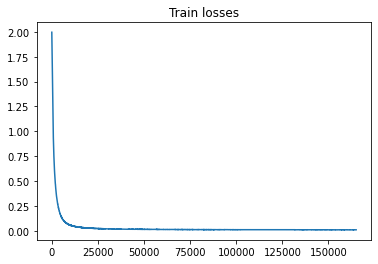

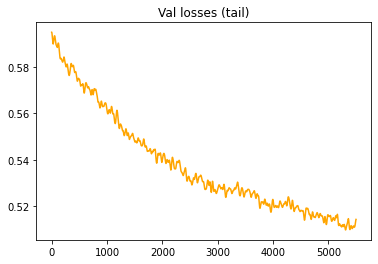

In [10]:
plt.plot(gaussian_filter1d(losses[:], 10))
plt.title("Train losses")
plt.show()
plt.plot(gaussian_filter1d(val_losses[2000:], 10), color='orange')
plt.title("Val losses (tail)")
plt.show()

In [11]:
# return 2 predicted ranks (replacing head and trail)
def accuracy_for_one(
    ent_emb: Tensor, 
    rel_emb: Tensor, 
    triplet: Tensor,
    p_norm: float
) -> Tuple[float, float]:
  num_nodes = ent_emb.shape[0]

  head = ent_emb[triplet[0]]
  label = rel_emb[triplet[1]]
  tail = ent_emb[triplet[2]]

  correct_diss = torch.norm(head + label - tail, p=p_norm)

  # calculating all dissimilarities with replaced head
  diss_with_head_replaced = torch.norm(
      ent_emb + (label - tail).repeat(num_nodes, 1),
      p=p_norm, dim=1
  )

  # calculating all dissimilarities with replaced tail
  diss_with_tail_replaced = torch.norm(
      (head + label).repeat(num_nodes, 1) - ent_emb,
      p=p_norm, dim=1
  )

  # rank among triplets with replaced head
  rank_heads = torch.sum(diss_with_head_replaced < correct_diss)
  # rank among triplets with replaced tail
  rank_tails = torch.sum(diss_with_tail_replaced < correct_diss)

  return (rank_heads.item(), rank_tails.item())

# return MR and Hits@10
def mean_accuracy(
    ent_emb: Tensor, 
    rel_emb: Tensor, 
    triplets: Tensor,
    p_norm: float
) -> Tuple[float, float]:
  ranks_sum = 0
  hits10 = 0

  for triplet in tqdm(triplets.t()):
    r1, r2 = accuracy_for_one(ent_emb, rel_emb, triplet, p_norm)
    ranks_sum += r1 + r2
    hits10 += (r1 < 10) + (r2 < 10)
  
  ranks_sum /= triplets.shape[1] * 2
  hits10 /= triplets.shape[1] * 2

  return ranks_sum, hits10

In [12]:
MR, HTS10 = mean_accuracy(
    model.get_entities_embs(), 
    model.get_relations_embs(), 
    test_triplets, 
    p_norm=1
)
print("Mean rank:", MR)
print("Hits@10:", HTS10)

  0%|          | 0/3134 [00:00<?, ?it/s]

Mean rank: 3890.0285577536692
Hits@10: 0.40587109125717935
